In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42

In [2]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
input_age = 'age.csv'
input_admission = 'admission.csv'
input_signal = 'signal.csv'
delimiter = ';'
data_age = pd.read_csv(input_age,sep = delimiter)
data_admission = pd.read_csv(input_admission ,sep = delimiter)
data_signal = pd.read_csv(input_signal,sep = delimiter)

In [4]:
from datetime import datetime, date, timedelta
data_admission['duration']= [int(i.days) for i in 
                             (pd.to_datetime(data_admission['date_discharge'])- pd.to_datetime(data_admission['date_admission']))]

In [5]:
data_all = [data_age,data_admission,data_signal]

In [6]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],
                                            how='left'), data_all)

In [7]:
df_groupby =df_merged.pivot_table('value', ['pat_id', 'age','date_admission','date_discharge','duration','day','hour'],'parameter')
df_groupby.reset_index( drop=False, inplace=True )

In [8]:
df_ts = df_groupby.sort_values(['date_admission', 'day'], ascending=[True, True])

In [9]:
df_ts['day'] = pd.to_datetime(df_ts['day'])
df_ts['day_w'] = df_ts['day'].map(lambda x: x.day)
df_ts['month'] = df_ts['day'].map(lambda x: x.month)
df_ts['year'] = df_ts['day'].map(lambda x: x.year)

In [10]:
## remove outliers and fill nan 
blood_pres_treshold = 250
df_ts = df_ts[df_ts['blood_pressure'] <= blood_pres_treshold]
df_ts['respiration_rate'].fillna(df_ts['respiration_rate'].mean(),inplace=True)
df_ts['temperature'].fillna(df_ts['temperature'].mean(),inplace=True)

In [11]:
## if patient readmitted after discharge 8 days
df_ts[['date_admission','date_discharge']] = df_ts[['date_admission','date_discharge']].\
                                                apply(lambda x: pd.to_datetime(x))
df_ts = df_ts.sort_values(['pat_id','date_admission']) #Thanks @Jondiedoop

df_ts['Readmit8']=df_ts.groupby('pat_id').apply(lambda x : (x['date_admission'].\
  shift(-1)-x['date_discharge']).dt.days.le(8).astype(int)).reset_index(0).drop('pat_id',1)
# print(df)
df_ts.shape

(68560, 14)

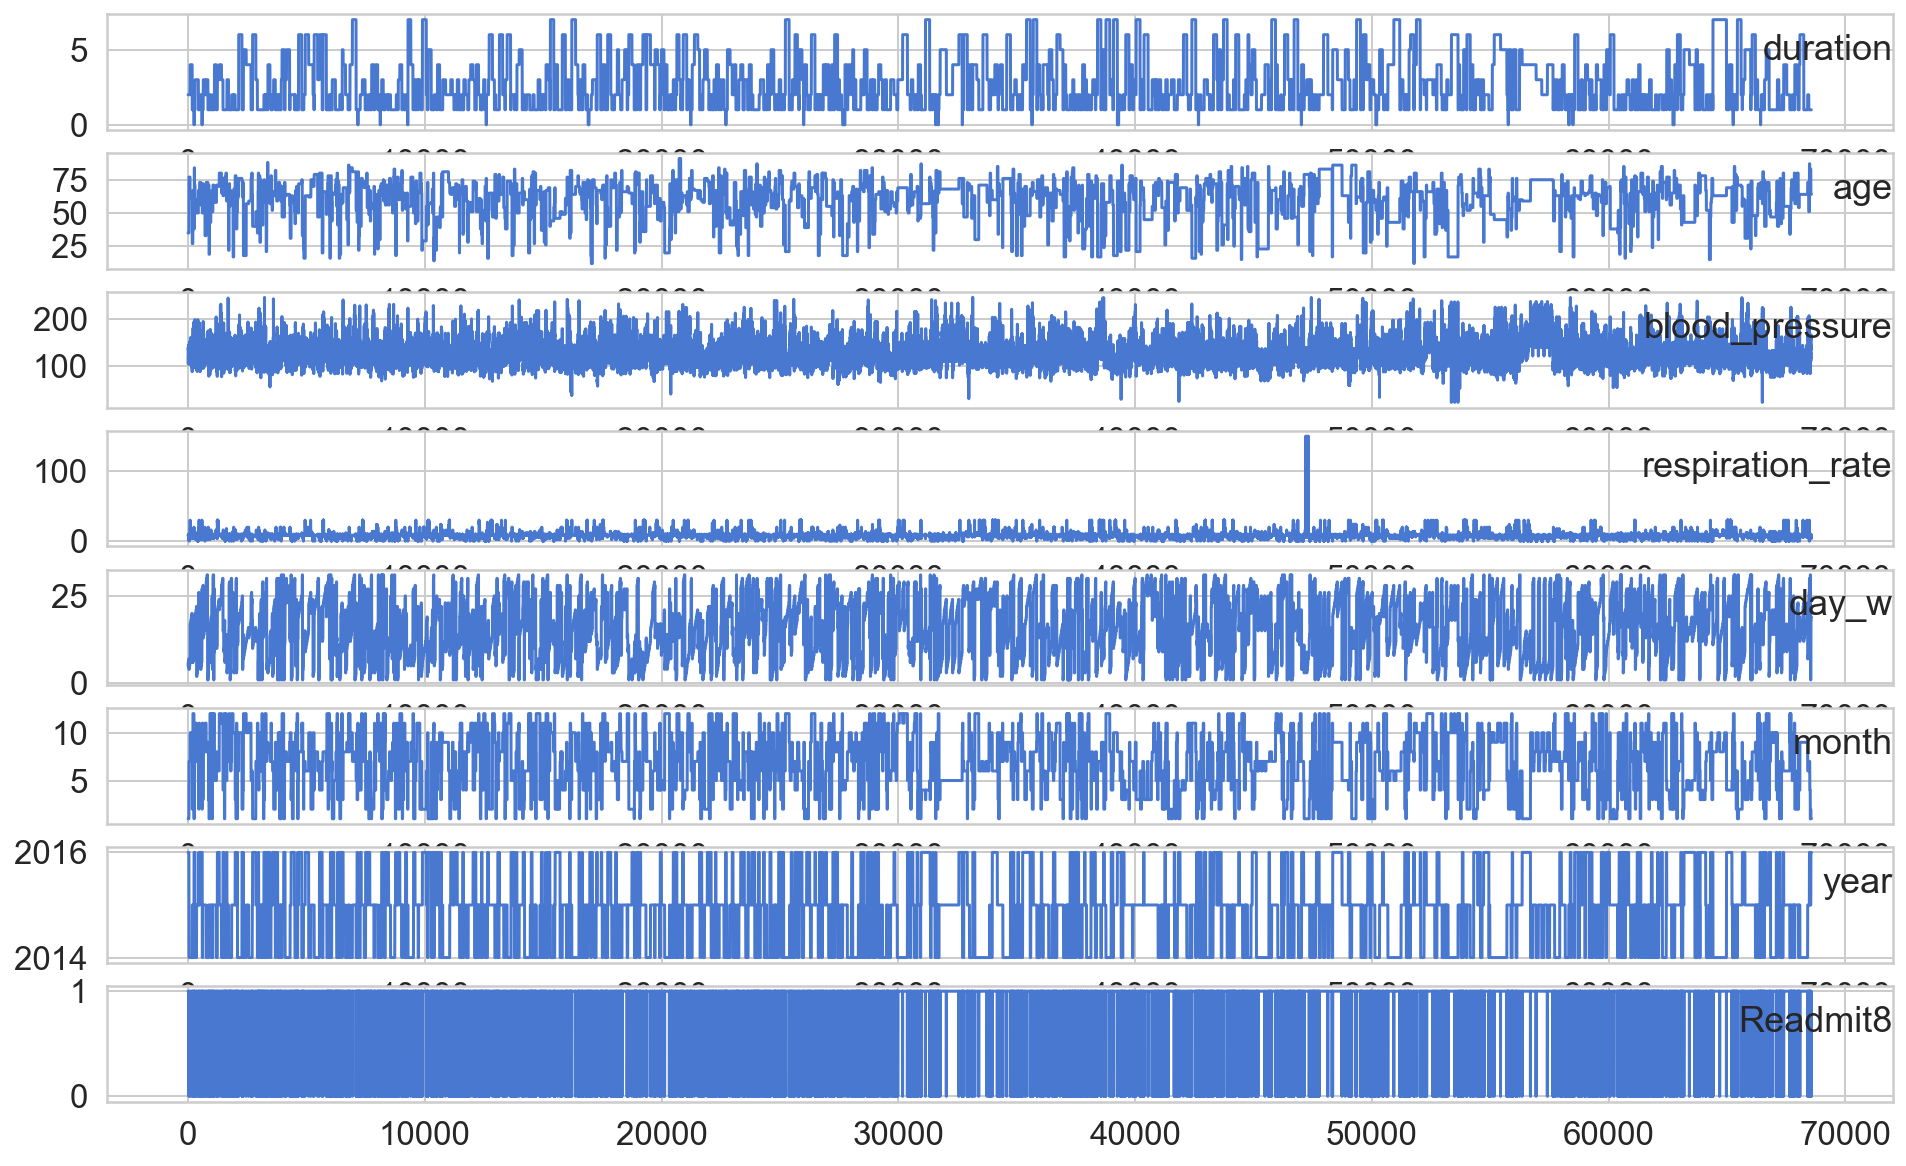

In [30]:
dataset = df_ts[['duration','age','blood_pressure','respiration_rate','temperature','day_w','month','year','Readmit8']]
dataset.to_csv('red.csv')
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7,8]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [13]:
# split train and test data , we use last 10% of the data as test
train_percentage = 0.9
train_size = int(len(dataset) * train_percentage)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(dataset)]
print(len(train), len(test))

61704 6856


In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
### features columns 
f_columns = ['duration','age','blood_pressure','respiration_rate','temperature','day_w','month','year']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

/Users/elham/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/elham/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [16]:
r_transformer = MinMaxScaler(feature_range=(0, 1))
r_transformer = r_transformer.fit(train[['Readmit8']])
train['Readmit8'] = r_transformer.transform(train[['Readmit8']])
test['Readmit8'] = r_transformer.transform(test[['Readmit8']])

<ipython-input-16-b19219006b91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Readmit8'] = r_transformer.transform(train[['Readmit8']])
<ipython-input-16-b19219006b91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Readmit8'] = r_transformer.transform(test[['Readmit8']])


In [17]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [18]:
#Each sequence is going to contain 10 data points from the history:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Readmit8, time_steps)
X_test, y_test = create_dataset(test, test.Readmit8, time_steps)

In [19]:
## check Dimension of train and test 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(61694, 10, 9) (61694,)
(6846, 10, 9) (6846,)


In [20]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history


Epoch 1/50
857/857 - 8s - loss: 0.0503 - val_loss: 0.0294
Epoch 2/50
857/857 - 7s - loss: 0.0283 - val_loss: 0.0251
Epoch 3/50
857/857 - 9s - loss: 0.0269 - val_loss: 0.0225
Epoch 4/50
857/857 - 8s - loss: 0.0257 - val_loss: 0.0224
Epoch 5/50
857/857 - 8s - loss: 0.0244 - val_loss: 0.0211
Epoch 6/50
857/857 - 7s - loss: 0.0241 - val_loss: 0.0211
Epoch 7/50
857/857 - 8s - loss: 0.0239 - val_loss: 0.0213
Epoch 8/50
857/857 - 9s - loss: 0.0233 - val_loss: 0.0206
Epoch 9/50
857/857 - 7s - loss: 0.0234 - val_loss: 0.0200
Epoch 10/50
857/857 - 7s - loss: 0.0235 - val_loss: 0.0208
Epoch 11/50
857/857 - 7s - loss: 0.0231 - val_loss: 0.0199
Epoch 12/50
857/857 - 7s - loss: 0.0233 - val_loss: 0.0213
Epoch 13/50
857/857 - 7s - loss: 0.0226 - val_loss: 0.0205
Epoch 14/50
857/857 - 7s - loss: 0.0227 - val_loss: 0.0211
Epoch 15/50
857/857 - 8s - loss: 0.0230 - val_loss: 0.0201
Epoch 16/50
857/857 - 8s - loss: 0.0225 - val_loss: 0.0199
Epoch 17/50
857/857 - 7s - loss: 0.0227 - val_loss: 0.0203
Epoch 

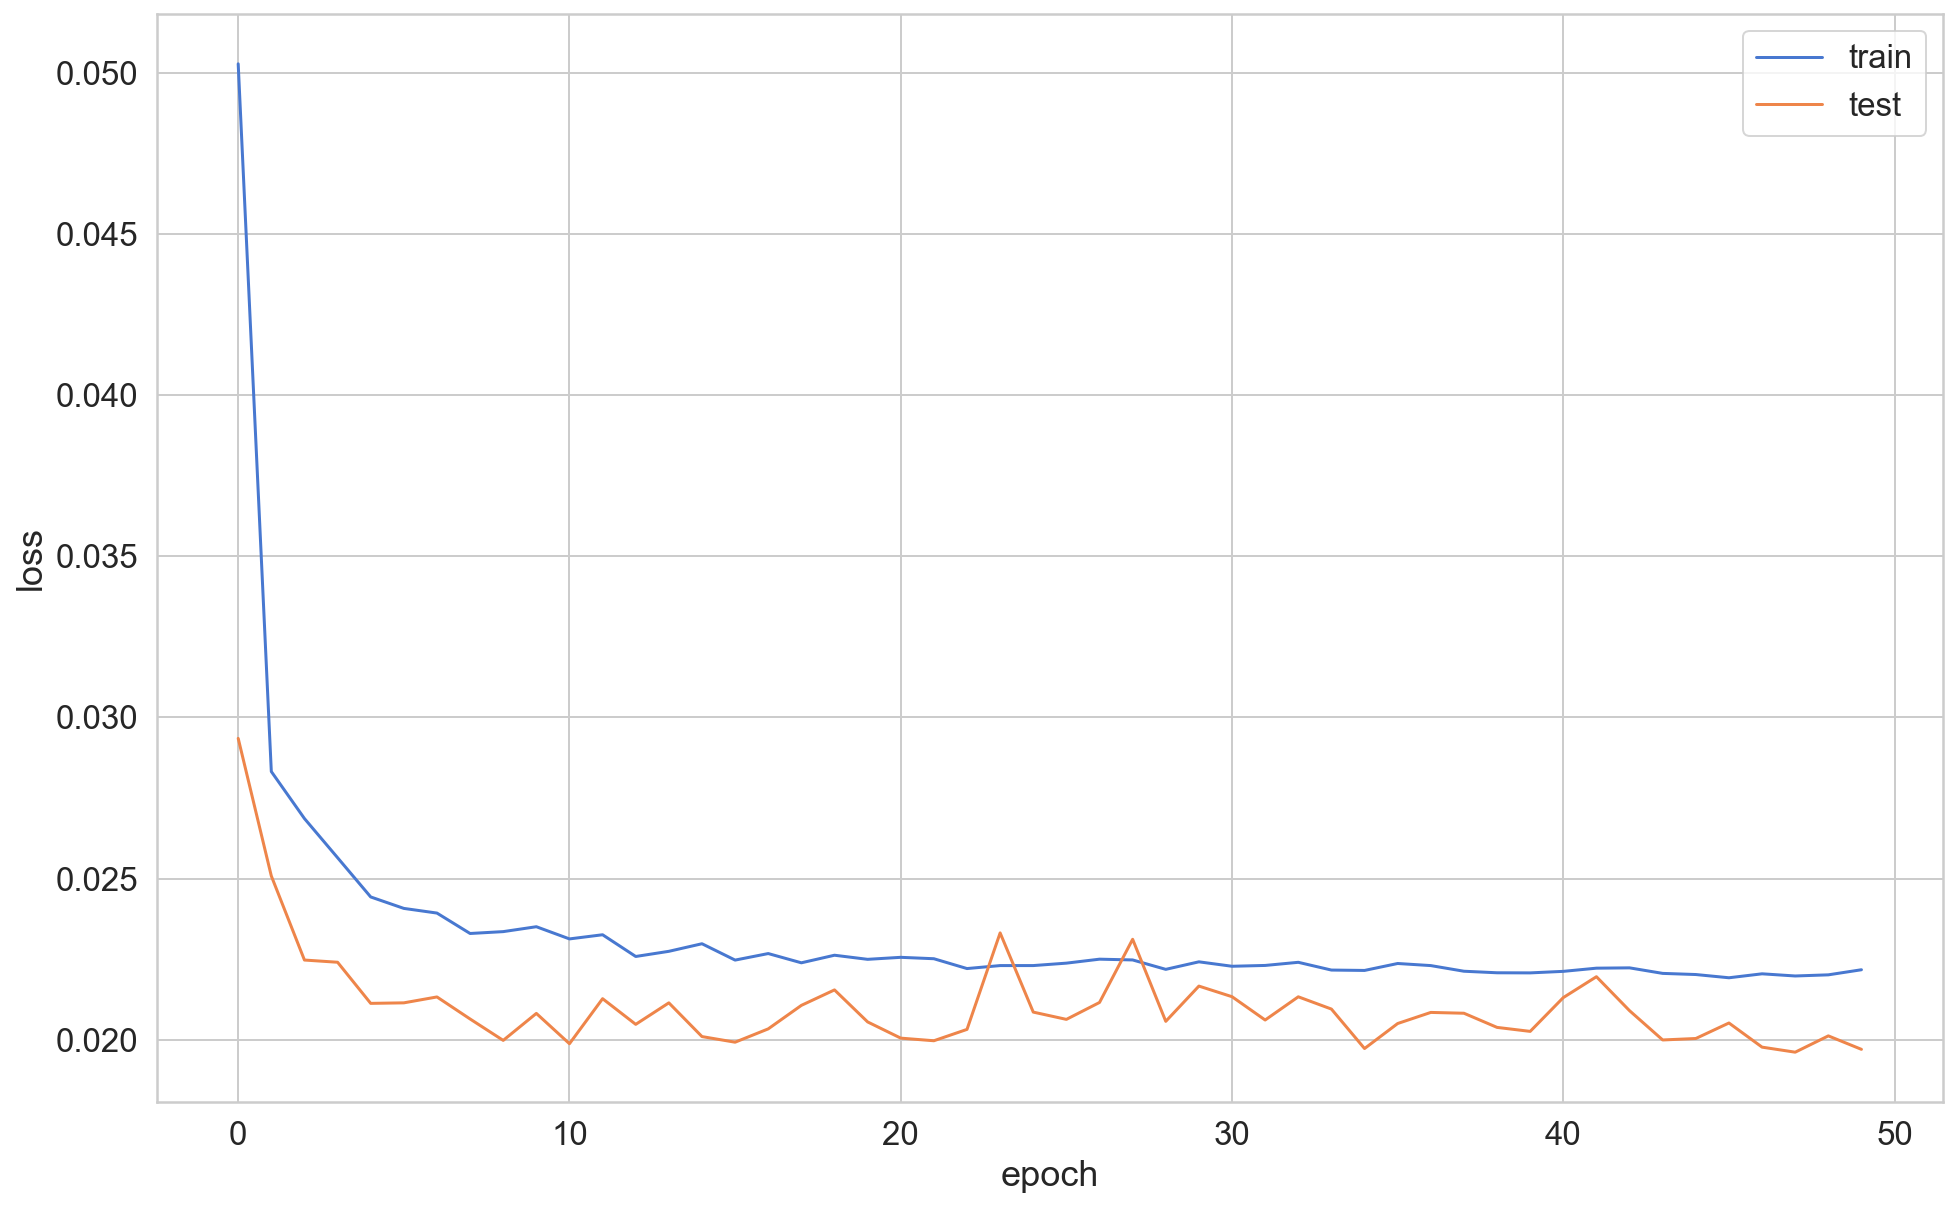

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

In [23]:
## check Dimension of train and test 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(61694, 10, 9) (61694,)
(6846, 10, 9) (6846,)


In [24]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = r_transformer.inverse_transform(trainPredict)
trainY = r_transformer.inverse_transform(y_train.reshape(1,-1))
testPredict = r_transformer.inverse_transform(testPredict)
testY = r_transformer.inverse_transform(y_test.reshape(1,-1))
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY, trainPredict.reshape(1,-1)))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY, testPredict.reshape(1,-1)))
print('Test Score: %.3f RMSE' % (testScore))


Train Score: 0.144 RMSE
Test Score: 0.139 RMSE


In [25]:
y = dataset['Readmit8'].values


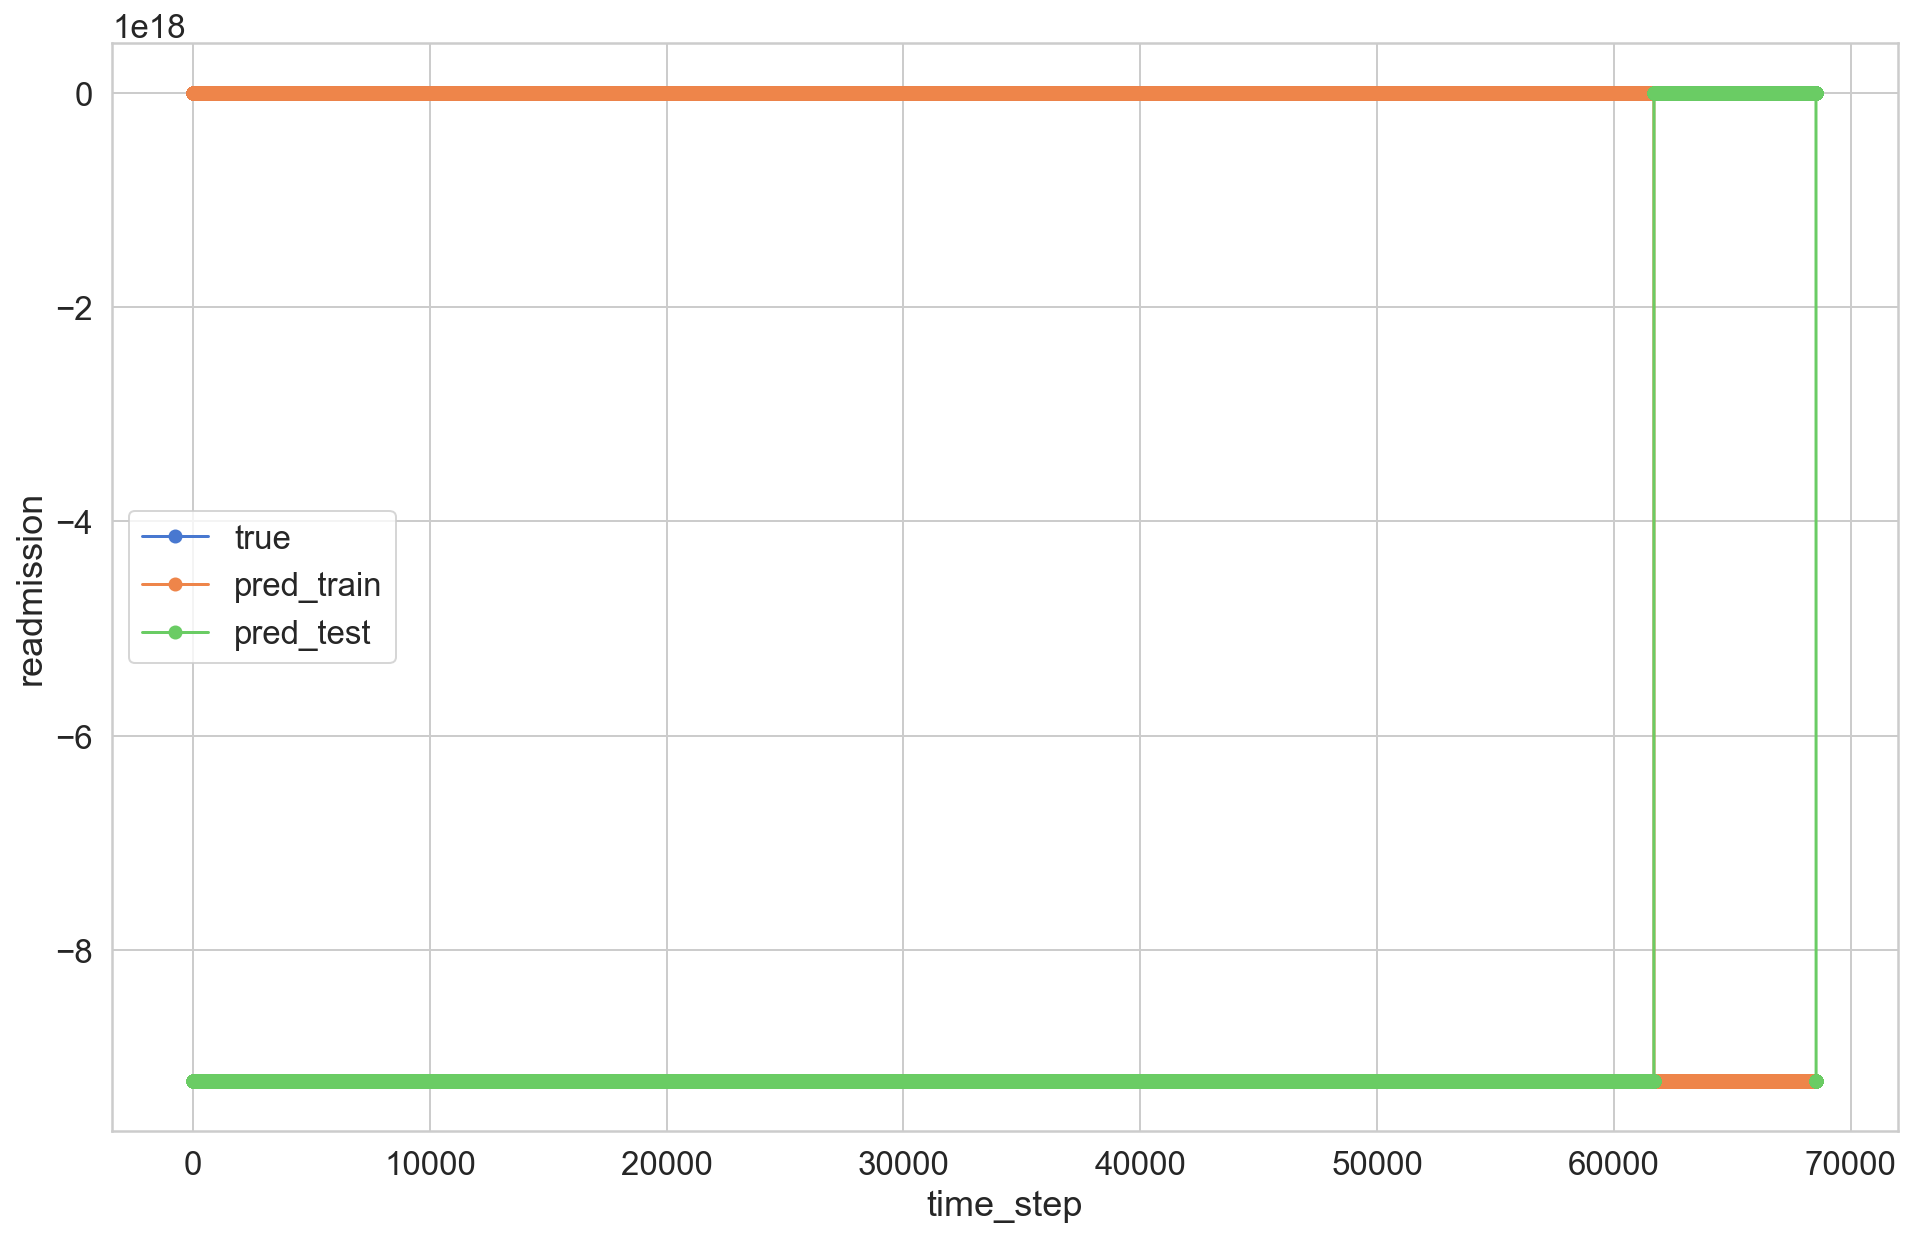

In [26]:
time_steps=10
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:]=np.nan
trainPredictPlot[0:len(trainPredict)] = trainPredict.reshape(1,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict):len(y)-2*time_steps] = testPredict.reshape(1,-1)
# plot baseline and predictions
plt.plot(y.flatten(),marker = 'o',label ='true')
plt.plot(trainPredictPlot,marker = 'o',label ='pred_train')
plt.plot(testPredictPlot,marker = 'o',label ='pred_test')
plt.xlabel('time_step')
plt.ylabel('readmission')
plt.legend()
plt.show()

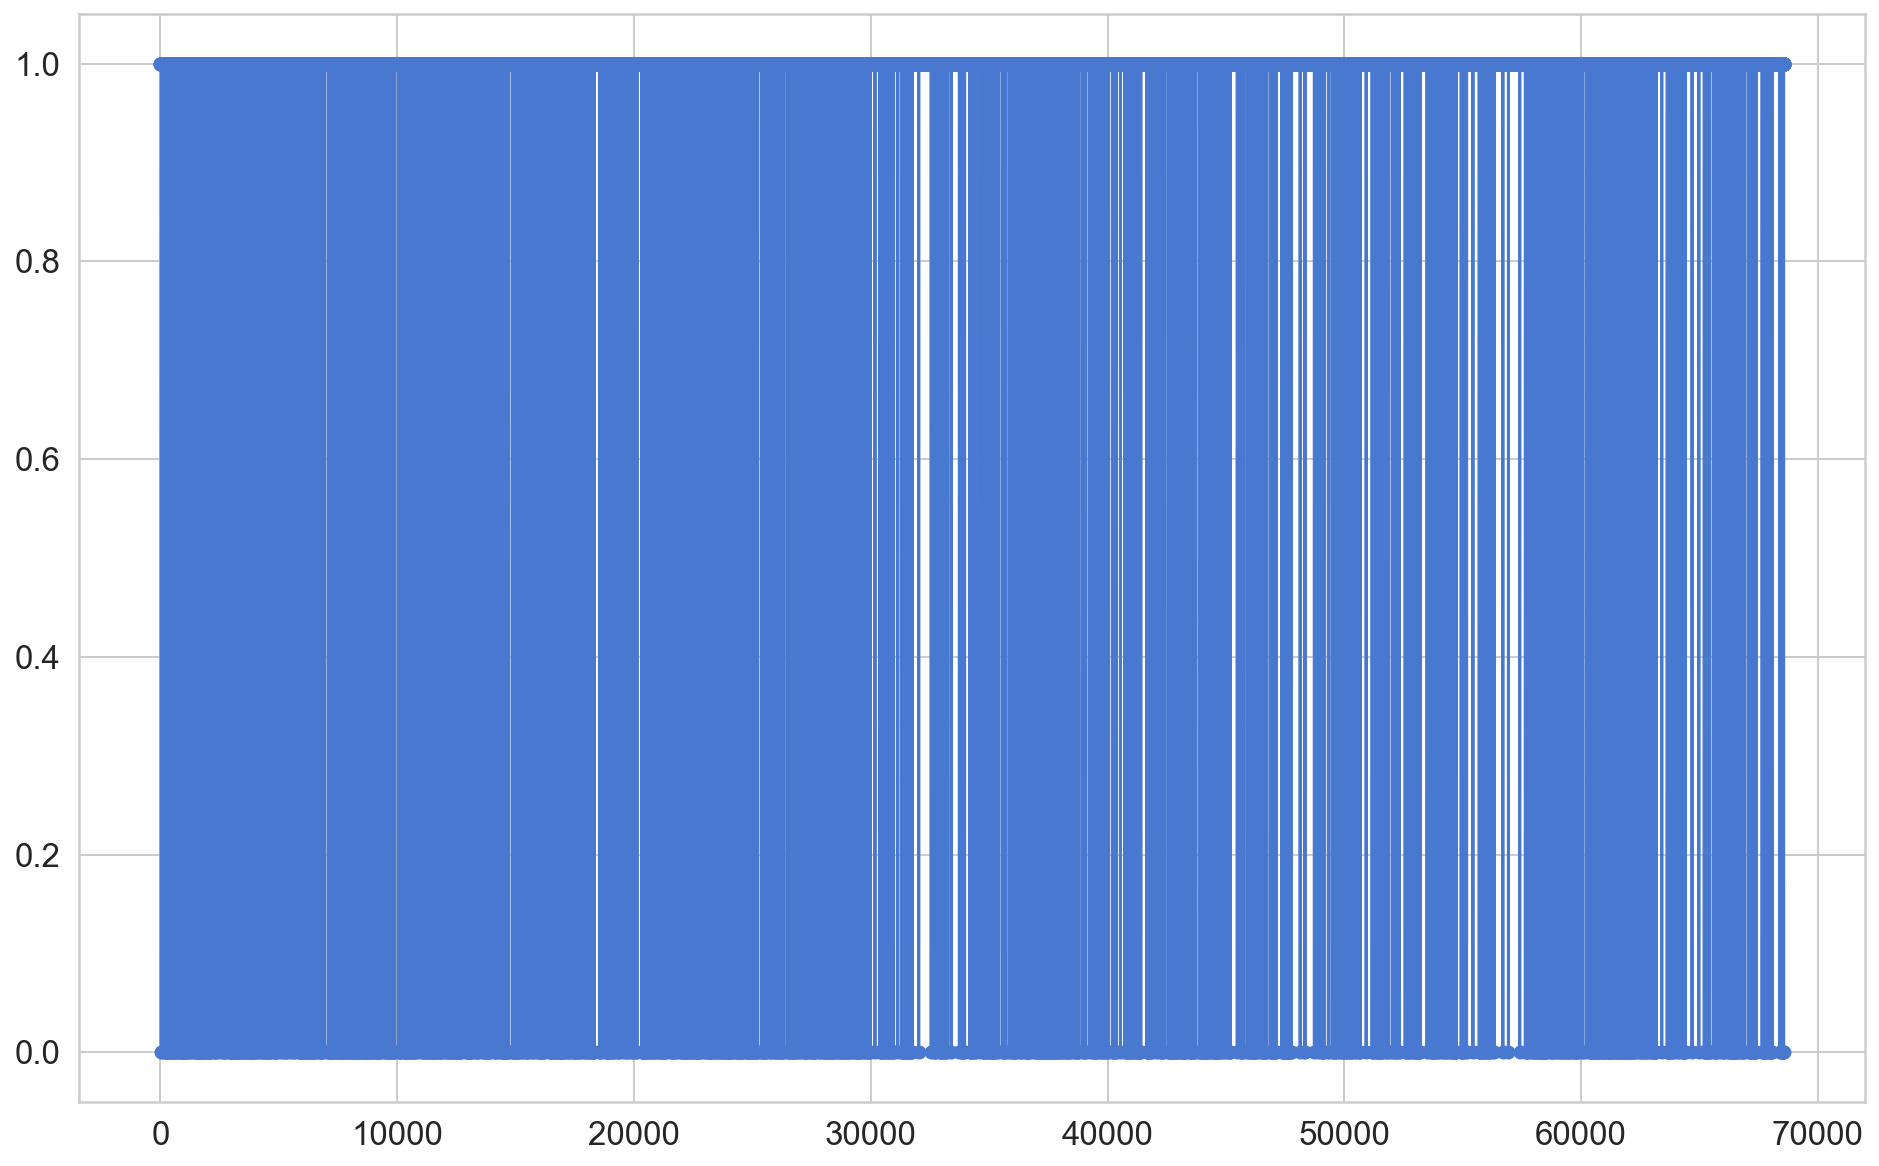

In [27]:
plt.plot(y.flatten(),marker = 'o',label ='true')

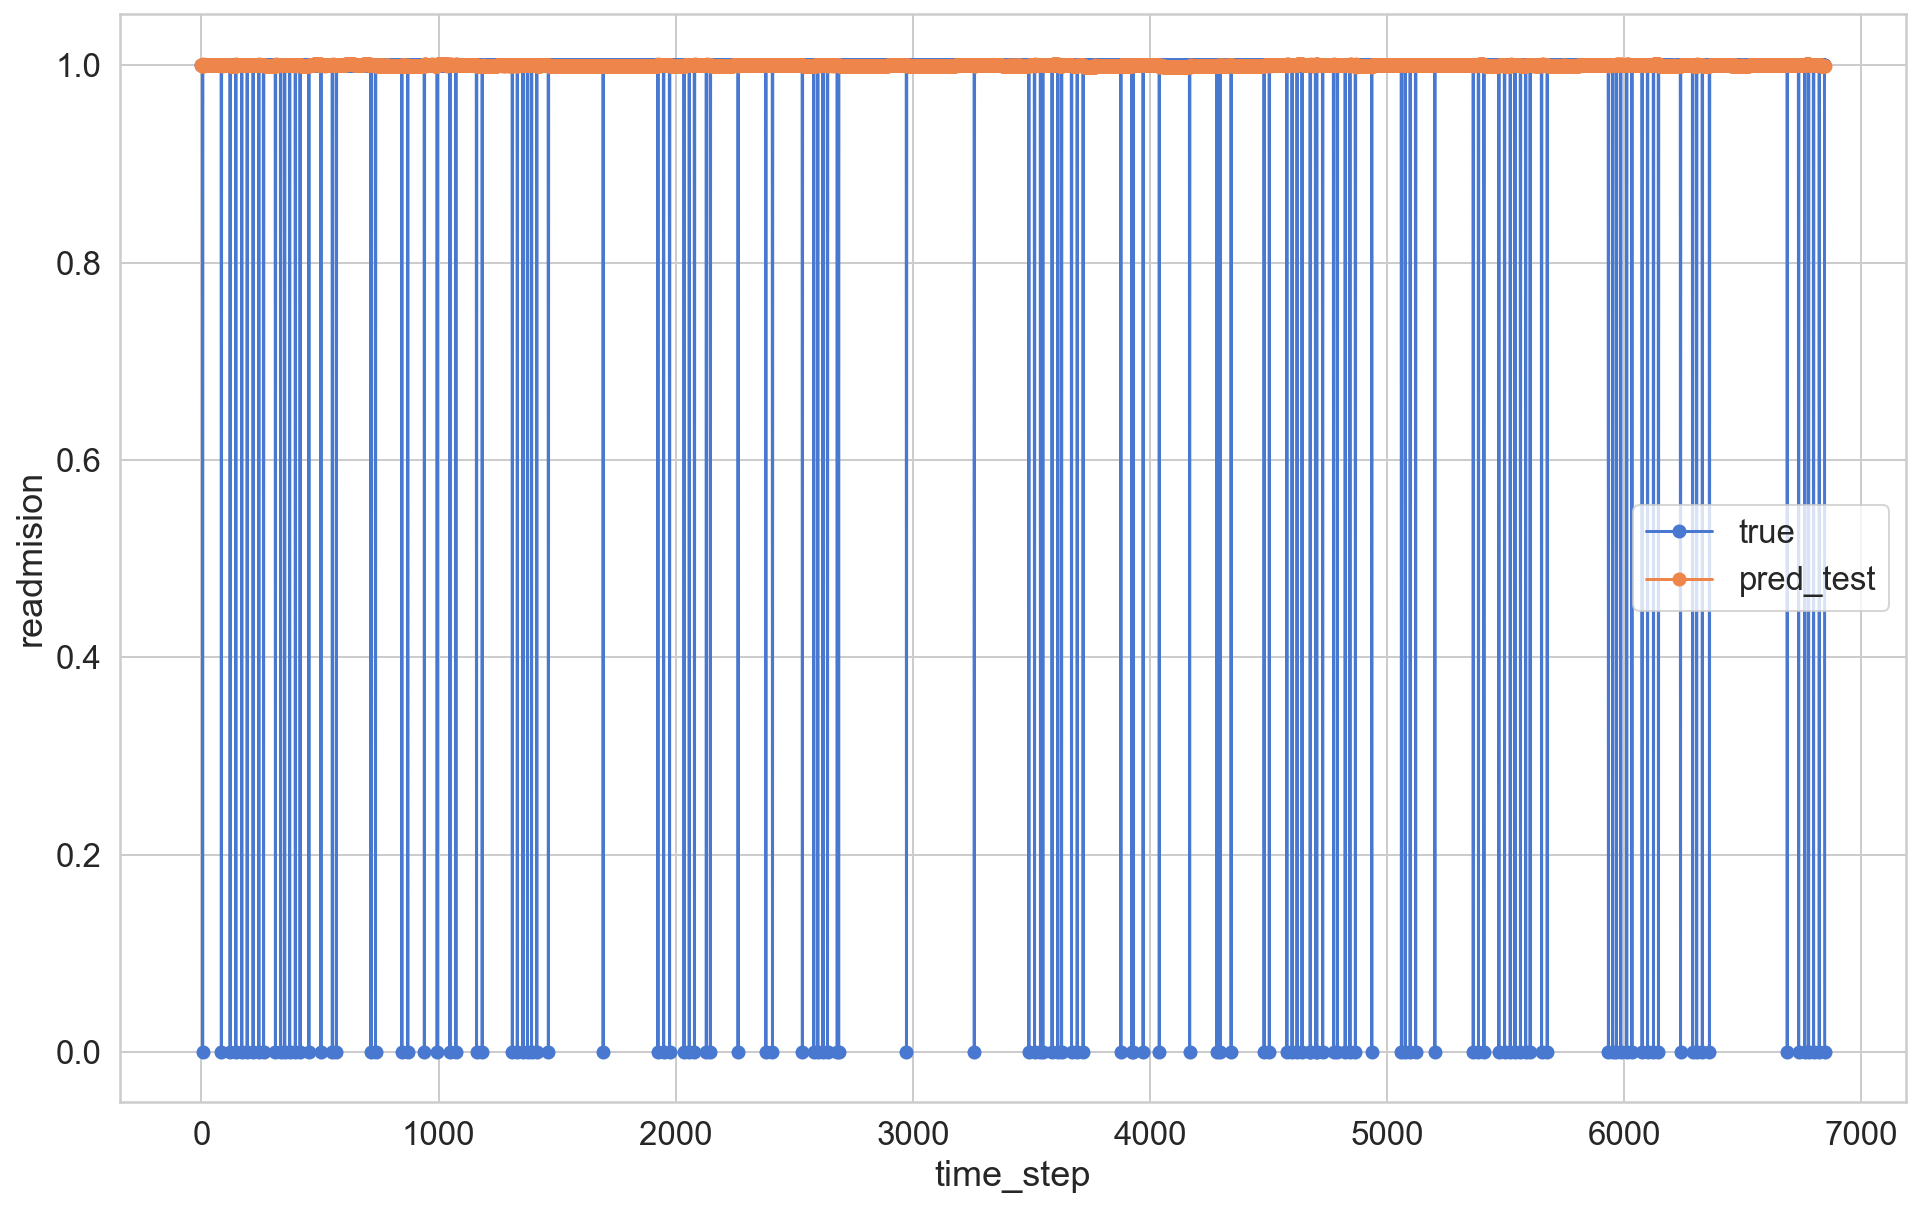

In [28]:
plt.plot(testY.flatten(),marker = 'o',label ='true')
plt.plot(testPredict.flatten(),marker = 'o',label ='pred_test')
plt.xlabel('time_step')
plt.ylabel('readmision')
plt.legend()

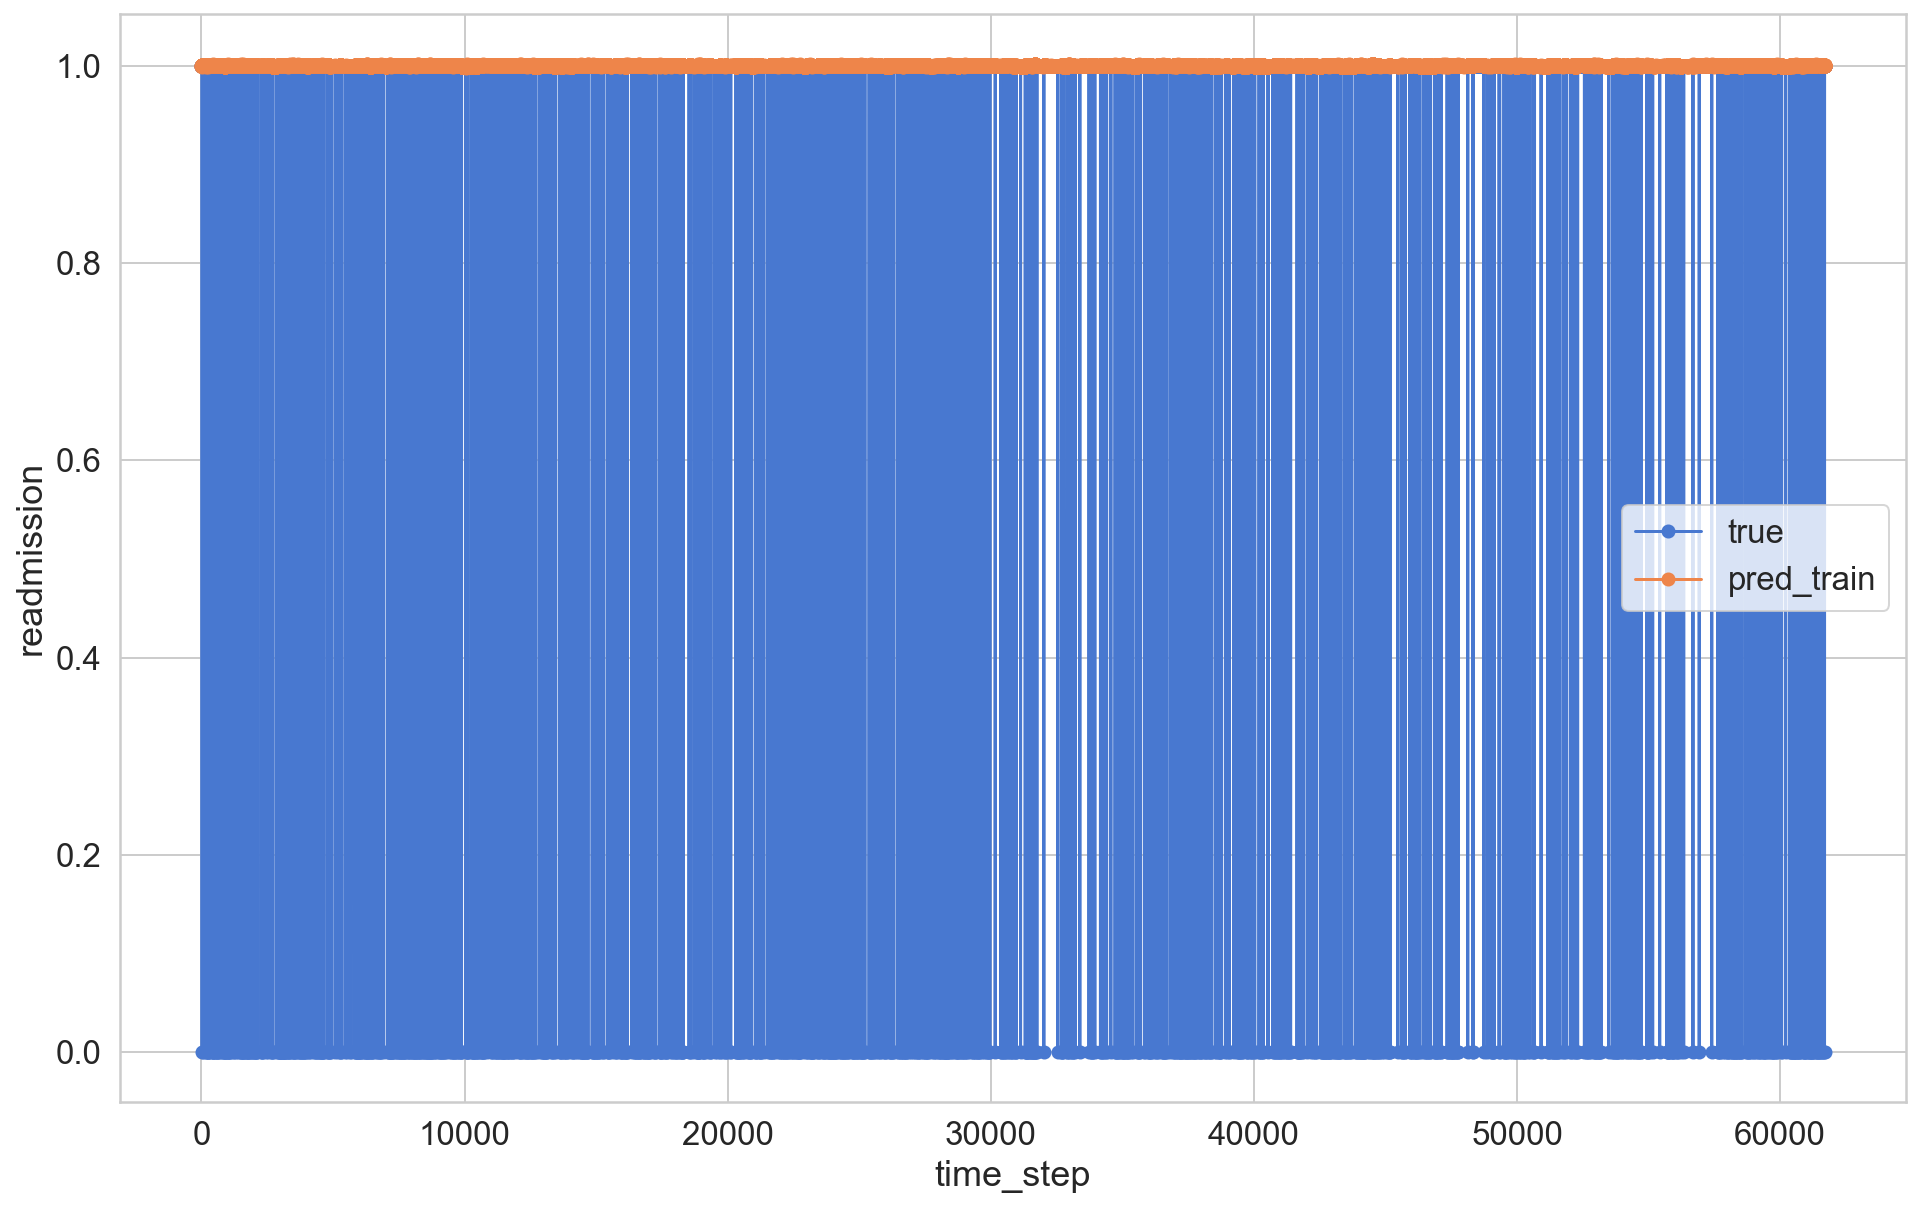

In [29]:
plt.plot(trainY.flatten(),marker = 'o',label ='true')
plt.plot(trainPredict.flatten(),marker = 'o',label ='pred_train')
plt.xlabel('time_step')
plt.ylabel('readmission')
plt.legend()